Added critic to the code found in 
https://github.com/higgsfield/np-hard-deep-reinforcement-learning/blob/master/Neural%20Combinatorial%20Optimization.ipynb

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA = False

In [2]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Creates a set of 2D coordinates of length 'num_samples'
class TSPDataset(Dataset):
    
    def __init__(self, num_nodes, num_samples, random_seed=111):
        super(TSPDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for l in tqdm(range(num_samples)):
            x = torch.FloatTensor(2, num_nodes).uniform_(0, 1)
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

In [4]:
train_size = 1000000
val_size = 10000

In [5]:
train_20_dataset = TSPDataset(20, train_size)
val_20_dataset   = TSPDataset(20, val_size)

train_50_dataset = TSPDataset(50, train_size)
val_50_dataset   = TSPDataset(50, val_size)

100%|██████████| 10000/10000 [00:00<00:00, 305277.85it/s]


In [162]:
study_dataset = TSPDataset(5, 2)

100%|██████████| 2/2 [00:00<00:00, 2593.88it/s]


In [175]:
#Returns a vector of size equal to the mini-batch size
def reward(sample_solution, USE_CUDA=False):
    """
    Args:
        sample_solution list of length 'seq_len' of [batch_size x input_size (2 since doing 2D coordinates)]
    """
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution)
    #print batch_size
    tour_len = Variable(torch.zeros([batch_size]))
    
    if USE_CUDA:
        tour_len = tour_len.cuda()

    for i in range(n - 1):
        tour_len += torch.norm(sample_solution[i] - sample_solution[i + 1], dim=1)
    
    tour_len += torch.norm(sample_solution[n - 1] - sample_solution[0], dim=1)

    return tour_len

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, name='Bahdanau', use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.C = C
        self.name = name
        
        if name == 'Bahdanau':
            self.W_query = nn.Linear(hidden_size, hidden_size)
            self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)

            V = torch.FloatTensor(hidden_size)
            if use_cuda:
                V = V.cuda()  
            self.V = nn.Parameter(V)
            self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
            
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        
        if self.name == 'Bahdanau':
            ref = ref.permute(0, 2, 1)
            query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
            ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len] 
            expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
            V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]
            logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
            
        elif self.name == 'Dot':
            query  = query.unsqueeze(2)
            logits = torch.bmm(ref, query).squeeze(2) #[batch_size x seq_len x 1]
            ref = ref.permute(0, 2, 1)
        
        else:
            raise NotImplementedError
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

In [8]:
class GraphEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda=USE_CUDA):
        super(GraphEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.use_cuda = use_cuda
        
        self.embedding = nn.Parameter(torch.FloatTensor(input_size, embedding_size)) 
        self.embedding.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        embedding = self.embedding.repeat(batch_size, 1, 1)  
        embedded = []
        inputs = inputs.unsqueeze(1)
        for i in range(seq_len):
            embedded.append(torch.bmm(inputs[:, :, :, i].float(), embedding))
        embedded = torch.cat(embedded, 1)
        return embedded

In [357]:
class Critic(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            num_processing,
            n_glimpses,
            use_cuda=USE_CUDA):
        super(Critic, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.num_processing = num_processing
        self.use_cuda       = use_cuda
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)  
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        #TODO change to Dima's and take care of dimensions of ref (i.e., permutation)
        self.glimpse = Attention(hidden_size, use_tanh=False, name='Dot', use_cuda=use_cuda)            
            
    def forward(self, inputs):
        """
        Args: 
            inputs: [batch_size x 1 x sourceL]
        """        
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        
        #The encoder simply runs the embedding
        encoder_outputs, (hidden, context) = self.encoder(embedded)       
        """encoder_outputs: [batch_size x seq_len x hidden_size]"""                
       
        #The first input to the decoder is the last hidden state
        decoder_input = torch.t(hidden) #Batch size has to be the first dimension, so swap first and second dimensions
        
        #Init decoder's hidden and reuse the encoder's context        
        hidden = Variable(torch.zeros(1, batch_size, hidden_size))
        context = Variable(torch.zeros(context.size()))
        
        #For each step in the sequence
        for i in range(self.num_processing):                        
            
            _, (hidden, context) = self.decoder(decoder_input, (hidden, context))
            
            query = hidden.squeeze(0) #[hidden_size x 1] (or the other way around)
            
            #Do the glimpse
            ref, logits = self.glimpse(query, encoder_outputs)
            #logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)           
                    
            #[batch_size x hidden_size]
            decoder_input = query.unsqueeze(1)
            
        #Do fully connected part   TODO: batch norm 
        output = self.fc1(query)
        output = F.relu(output)
        output = self.fc2(output)
            
        #list of seq_len containing[batch_size x seq_len], list of seq_len containing [batch_size]    
        return output

In [300]:
class PointerNet(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            attention,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, name=attention, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, name=attention, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    """"
    idxs: indeces that were previously chosen
    logits: probabilities for current step
    """"
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs):
        """
        Args: 
            inputs: [batch_size x 1 x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        
        #The encoder simply runs the embedding
        encoder_outputs, (hidden, context) = self.encoder(embedded)        
        
        prev_probs = []
        prev_idxs = []
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        #The first input to the decoder is learned, as in the paper
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        #For each step in the sequence
        for i in range(seq_len):                                        
                
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0) #[hidden_size x 1] (or the other way around)
            
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)                 
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            #[batch size x seq_len]
            probs = F.softmax(logits)
            
            #Give me the index that will be chosen: [batch_size]
            idxs = probs.multinomial().squeeze(1)
            
            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).data.any():
                    print seq_len
                    print(' RESAMPLE!')
                    idxs = probs.multinomial().squeeze(1)
                    break
                    
            #[batch_size x hidden_size]
            decoder_input = embedded[range(batch_size), idxs.data, :] 
            
            prev_probs.append(probs)
            prev_idxs.append(idxs)
            
        #list of seq_len containing[batch_size x seq_len], list of seq_len containing [batch_size]    
        return prev_probs, prev_idxs 

In [312]:
class CombinatorialRL(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            reward,
            attention,
            use_cuda=USE_CUDA):
        super(CombinatorialRL, self).__init__()
        self.reward = reward
        self.use_cuda = use_cuda
        
        self.actor = PointerNet(
                embedding_size,
                hidden_size,
                seq_len,
                n_glimpses,
                tanh_exploration,
                use_tanh,
                attention,
                use_cuda)
        
        self.critic = Critic(embedding_size=embedding_size,
            hidden_size=hidden_size,
            seq_len=seq_len,
            num_processing=3,
            n_glimpses=n_glimpses,
            use_cuda=use_cuda)

    def forward(self, inputs):
        """
        Args:
            inputs: [batch_size, input_size, seq_len]
        """
        batch_size = inputs.size(0)
        input_size = inputs.size(1) #2 because we are doing 2D coordinates
        seq_len    = inputs.size(2)        
                
        #list of seq_len containing[batch_size x seq_len], list of seq_len containing [batch_size]    
        probs, action_idxs = self.actor(inputs)
                        
        critic_evals = self.critic(inputs)
        
#         print ("Combinatorial RL (inputs)")
#         print (inputs)
        #print ("Combinatorial RL (action_idxs.size): ", action_idxs)
       
        actions = []
        
        """
        Transpose the inputs to have [batch_size, seq_len, input_size]
        """
        inputs = inputs.transpose(1, 2)
        
        #List of size seq_len
        for action_id in action_idxs:
            actions.append(inputs[range(batch_size), action_id.data, :])
            
        #actions now has the coordinates in the solution
            
        action_probs = []    
        #List of size seq_len
        for prob, action_id in zip(probs, action_idxs):
            #We want to know the probability of taking each action (picking city) in the solution
            action_probs.append(prob[range(batch_size), action_id.data])

        #R is [batch_size x 1]
        R = self.reward(actions, self.use_cuda)
        #print ("Total reward: ", R)
        
        return R, action_probs, actions, action_idxs, critic_evals

In [212]:
embedding_size = 128
hidden_size    = 128
n_glimpses = 1
tanh_exploration = 10
use_tanh = True

beta = 0.9
max_grad_norm = 2.

In [358]:
tsp_20_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        20,
        n_glimpses, 
        tanh_exploration,
        use_tanh,
        reward,
        attention="Dot",
        use_cuda=USE_CUDA)

tsp_50_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        50,
        n_glimpses, 
        tanh_exploration,
        use_tanh,
        reward,
        attention="Bahdanau",
        use_cuda=USE_CUDA)

tsp_5_model = CombinatorialRL(
        embedding_size,
        hidden_size,
        5,
        n_glimpses,
        tanh_exploration,
        use_tanh,
        reward,
        attention='Dot',
        use_cuda=False)

In [359]:
class TrainModel:
    def __init__(self, model, train_dataset, val_dataset, batch_size=128, threshold=None, max_grad_norm=2.):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset   = val_dataset
        self.batch_size = batch_size
        self.threshold = threshold
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
        self.val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=1e-4)
        self.critic_optim  = optim.Adam(model.critic.parameters(), lr=1e-3)
        
        self.max_grad_norm = max_grad_norm
        
        self.train_tour = []
        self.val_tour   = []
        
        self.epochs = 0
    
    def train_and_validate(self, n_epochs):
        critic_exp_mvg_avg = torch.zeros(1)
        critic_loss_criterion = torch.nn.MSELoss()        
        
        if USE_CUDA: 
            critic_exp_mvg_avg = critic_exp_mvg_avg.cuda()

        for epoch in range(n_epochs):
            for batch_id, sample_batch in enumerate(self.train_loader):
                self.model.train()
                
                inputs = Variable(sample_batch)
                
                if USE_CUDA:
                    inputs = inputs.cuda()

                #Model is combinatorial
                R, probs, actions, actions_idxs, values = self.model(inputs)

                if batch_id == 0:
                    critic_exp_mvg_avg = R.mean()
                else:
                    critic_exp_mvg_avg = (critic_exp_mvg_avg * beta) + ((1. - beta) * R.mean())

                #Vector of length equal to the mini-batch size: Q(s,a) - V(s)
                #advantage = R - critic_exp_mvg_avg
                
                advantage = R.unsqueeze(1) - values        

                logprobs = 0
                for prob in probs: 
                    logprob = torch.log(prob)
                    logprobs += logprob
                    
                #logprobs[logprobs < -1000] = 0. #Works with PyTorch 2.0
                                
                #For Pytorch 3.0                                
                if logprobs.data[0] < -1000:
                    print (logprobs.data[0])
                    logprobs = Variable(torch.FloatTensor([0.]), requires_grad=True)

                reinforce = advantage * logprobs
                actor_loss = reinforce.mean()

                self.actor_optim.zero_grad()                
                actor_loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm(self.model.actor.parameters(),
                                    float(self.max_grad_norm), norm_type=2)

                self.actor_optim.step()
                
                #Do critic gradient descent
                self.critic_optim.zero_grad()
                loss_critic = critic_loss_criterion(values, R.unsqueeze(1))
                loss_critic.backward()
                torch.nn.utils.clip_grad_norm(self.model.critic.parameters(),
                    float(self.max_grad_norm), norm_type=2)

                self.critic_optim.step()
                print ("Critic's loss: ", loss_critic.data[0])
                

                #critic_exp_mvg_avg = critic_exp_mvg_avg.detach()

                self.train_tour.append(R.mean().data[0])

                if batch_id % 10 == 0:
                    self.plot(self.epochs)

                if batch_id % 100 == 0:    

                    self.model.eval()
                    for val_batch in self.val_loader:
                        inputs = Variable(val_batch)
                        
                        if USE_CUDA:
                            inputs = inputs.cuda()

                        R, probs, actions, actions_idxs, values = self.model(inputs)
                        self.val_tour.append(R.mean().data[0])

            if self.threshold and self.train_tour[-1] < self.threshold:
                print "EARLY STOPPAGE!"
                break
                
            self.epochs += 1
                
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_tour[-1] if len(self.train_tour) else 'collecting'))
        plt.plot(self.train_tour)
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_tour[-1] if len(self.val_tour) else 'collecting'))
        plt.plot(self.val_tour)
        plt.grid()
        plt.show()

In [360]:
tsp_20_train = TrainModel(tsp_20_model, 
                        train_20_dataset, 
                        val_20_dataset, 
                        threshold=3.99)

tsp_5_train = TrainModel(tsp_5_model, study_dataset,
                        study_dataset, threshold=3.99)

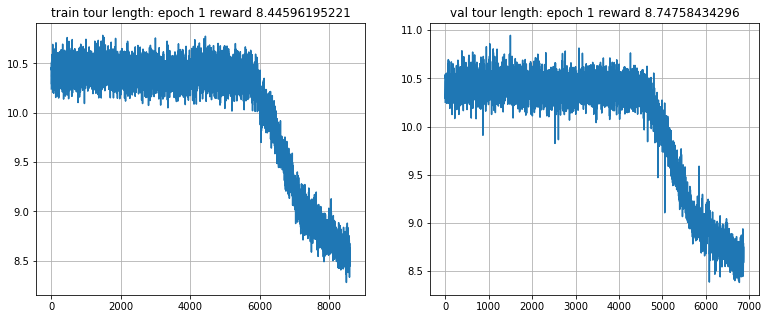

("Critic's loss: ", 0.9443957805633545)


In [ ]:
tsp_20_train.train_and_validate(5)